# Introduction
Hello people, welcome to this kernel. In this kernel I am going to generate digits using MNIST dataset and DCGANs (Deep Convolutional Generative Adverserial Networks) structure.

Before starting, let's take a look at the content of this kernel

# Notebook Content
1. What is GANs
1. Importing Libraries and Loading Data
1. The Generator and The Discriminator
1. Loss Functions and Optimizers
1. Training Model
1. Generating Digits
1. Conclusion


# What is GANs
GANs is a structure that generates data similar to the dataset. In general, GANs are to be used with image dataset and texts. As you can understand from the name of GANs, it includes more than one networks.

First network's name is Generator, it generates images using a random noise (random numbers with shape 100,) 

Second network's name is Discriminator, it tries to understand whether picture that came to it real or fake.

In Generator model, we'll use Convolutional 2D Transpose layers, thanks to this layers we can upsample the data. And in Discriminator, we will use classic Convolutional 2D Layer.

In both, we will use LeakyReLU as activation function and binary crossentropy as loss function. We will use LeakyReLU because it solves vanishing gradient problem.

I've explained everything, now let's take a look at the diagram below

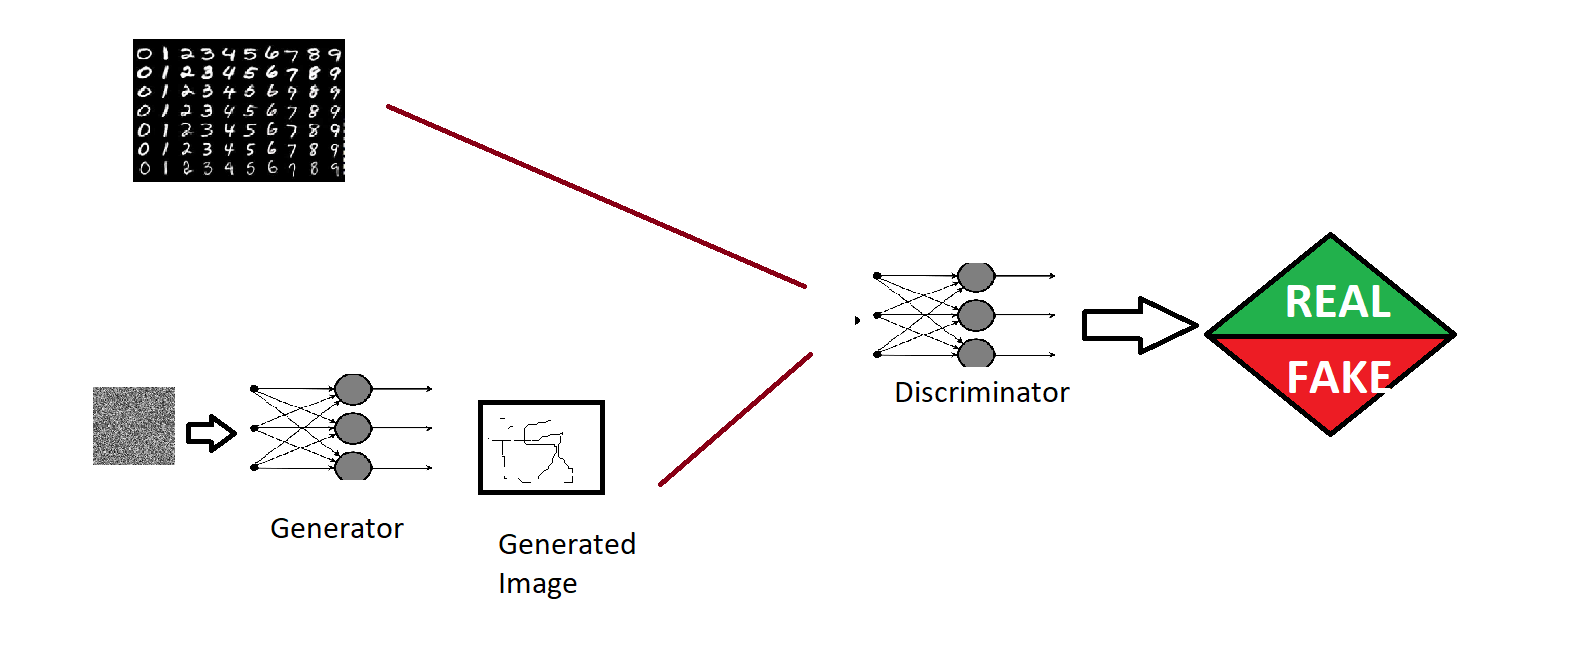


# Importing Libraries and Load The Data
In this section I am going to import the libraries that we need and load the data. 

In this kernel I will use Keras (Tensorflow backend)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

print(train_images.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


* There are 60K images in MNIST dataset's train set.
* Let's check some random sample

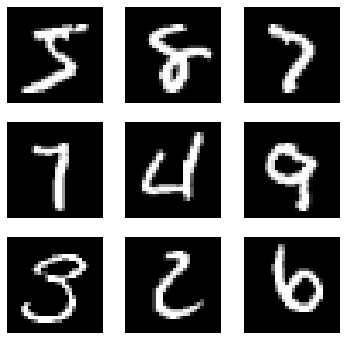

In [3]:
fig = plt.figure(figsize=(6,6))

for i in range(9):
    fig.add_subplot(3,3,i+1)
    plt.imshow(train_images[312*i],cmap="gray")
    plt.axis("off")

plt.show()

* Now we'll scale images between -1 and 1, like tanh function.

In [4]:
# 1x784 to 28x28 
train_images = train_images.reshape(-1,28,28,1).astype("float32")

# scaling between -1 and 1
train_images = (train_images-127.5) / 127.5

train_images.shape

(60000, 28, 28, 1)

* Our data is ready, last step is shuffling and batching the data.

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# The Generator and The Discriminator
In this section I am going to create generator and discriminator. I will start with generator.

In [6]:
# Generator Model

def make_generator():
    """
    This function returns generator model
    """
    model = tf.keras.models.Sequential()
    # This model will take 100x1 random noise (seed) as input
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Reshaping 
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256) # None is batch size
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding="same",use_bias=False))
    assert model.output_shape == (None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",use_bias=False))
    assert model.output_shape == (None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",use_bias=False))
    # We've used 1 as channel size because our digits are grayscale.
    # You can use 3 channel size in your RGB projects.
    assert model.output_shape == (None,28,28,1)
    
    return model

* Let's create a generator using this function.

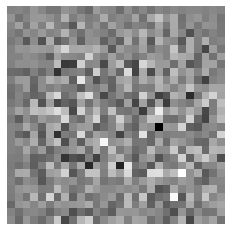

In [7]:
generator = make_generator()
# Let's use this untrained generator

noise = tf.random.normal([1,100])
bullshit_image = generator(noise,training=False)
plt.imshow(bullshit_image[0,:,:,0],cmap="gray")
plt.axis("off")
plt.show()


* Looks like random noise :))

Our generator is ready, but still we need a discriminator, discriminator is easier than generator, it is a CNN based classifier. Let's create it.

In [8]:
def make_discriminator():
    
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(28,28,1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    
    # Real or fake
    model.add(layers.Dense(1))
    
    return model

In [9]:
discriminator = make_discriminator()


* Let's use this untrained discriminator in order to detect whether generated image real or not.

In [10]:
decision = discriminator(bullshit_image)
print(decision)

tf.Tensor([[0.00332966]], shape=(1, 1), dtype=float32)


# Loss Functions and Optimizers
In this section I am going to define loss functions and optimizers of the networks.

In [11]:
# we'll use cross entropy loss 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output,fake_output):
    # ones_like => Creates a tensor of all ones that has the same shape as the input.
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    # zeros_like => Creates a tensor of all zeros that has same shape as the input
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Discriminator loss is ready, let's create generator loss.

In [12]:
def generator_loss(fake_output):
    # We've labeled fake outputs as one because generator will try to fool discriminator
    return cross_entropy(tf.ones_like(fake_output),fake_output)

* Our losses are ready, let's create optimizer. 
* As optimizer, we will use Adam.

In [13]:
# Learning rate ==> 1e-4 ===> 0.0001
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Saving checkpoints

In [14]:
import os
checkpoint_dir = "./"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator
                                )

# Training Model
In this section I am going to train our GANs model. 

* First, I'll define train_step function.

In [15]:
EPOCHS = 50
noise_dim = 100

# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])
    
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        
        generated_images = generator(noise,training=True)
        
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

* I know, it looks a bit confusing but I will explain as much as I can.

1. This function takes one batch image
1. First we've created a random noise, we'll use this random noise when we generate image using generator.
1. Then, we've generated images using random noise.
1. We've sent real images to discriminator and took decisions of discriminator
1. We've sent fake images (generated images) to discriminator as well and took decisions of discriminator.

1. Using this decisions, we've computed gen_loss and disc_loss.
1. And thanks to this lossess we've computed gradients of generator and discriminator, now we can update our model using these gradients
1. Finally we've updated our generator and optimizer.

I hope I can explain everything clear. Let's move on.

In [16]:
def train(dataset,epochs):
    
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # save model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print("""Epoch {}/{} is finished, process time {} seconds.
        =============================================================""".format(epoch+1,epochs,(time.time()-start)))
            
            

* Everything is ready, now we can train our GANs. I feel very excited, what about you?

In [17]:
train(train_dataset,EPOCHS)

Epoch 1/50 is finished, process time 8.902418613433838 seconds.
Epoch 2/50 is finished, process time 6.665543079376221 seconds.
Epoch 3/50 is finished, process time 6.638756275177002 seconds.
Epoch 4/50 is finished, process time 6.643808126449585 seconds.
Epoch 5/50 is finished, process time 6.616767168045044 seconds.
Epoch 6/50 is finished, process time 6.810367107391357 seconds.
Epoch 7/50 is finished, process time 6.621183156967163 seconds.
Epoch 8/50 is finished, process time 6.797022104263306 seconds.
Epoch 9/50 is finished, process time 6.644778728485107 seconds.
Epoch 10/50 is finished, process time 6.656028985977173 seconds.
Epoch 11/50 is finished, process time 6.641012907028198 seconds.
Epoch 12/50 is finished, process time 6.639829158782959 seconds.
Epoch 13/50 is finished, process time 6.612431287765503 seconds.
Epoch 14/50 is finished, process time 6.6563239097595215 seconds.
Epoch 15/50 is finished, process time 6.720948696136475 seconds.
Epoch 16/50 is finished, process 

# Generating Digits 
In this section we'll generate some digits.

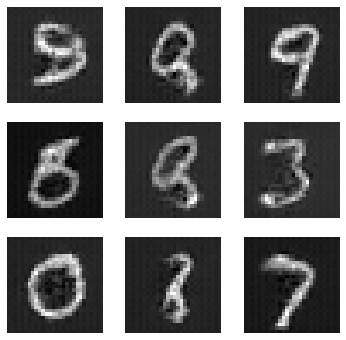

In [21]:
test_noise = tf.random.normal([9,100])
new_images = generator(test_noise,training=False)

fig = plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.axis("off")
    plt.imshow(new_images[i,:,:,0] * 127.5 + 127.5,cmap="gray")

    

These digist are not in the dataset, we generated it !!!!

# Conclusion
Thanks for your attention, if you have any question in your mind, please ask, I will definetely return.

Tutorial from tensorflow docs: https://www.tensorflow.org/tutorials/generative/dcgan
